In [1]:
"""SANITY CHECK FOR:
1) LID estimation: check whether the high LID images actually look more complex
2) reconstruction loss: check the organization of batches.
"""

'SANITY CHECK FOR:\n1) LID estimation: check whether the high LID images actually look more complex\n2) reconstruction loss: check the organization of batches.\n'

In [1]:
import json
import numpy as np
import os
# add the parent directory to the Python path
import sys
sys.path.append(os.path.abspath("../.."))   # one level up from notebook/
import matplotlib.pyplot as plt
import torch
from data.utils.dataloaders import get_imagenet_dataloader


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# save json file
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/flextok_based/original_images/val/t_0.32/lid_0000_0329.json', 'r') as f:
    lids = json.load(f)

lids = [lids[i] for i in range(0, len(lids), 2)]
print(len(lids))

50000


In [3]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

In [4]:
imagenet_val = get_imagenet_dataloader(split="val_categorized", batch_size=4)

In [5]:
# find the indices of lowest and highest LID values
lids_np = np.asarray(lids, dtype=np.float64)
# argsort returns indices that would sort the array ascending
order = np.argsort(lids_np)
lowest_indices = order[:50].tolist()
highest_indices = order[-50:][::-1].tolist()  # top 20 in descending order
lowest_values = lids_np[lowest_indices].tolist()
highest_values = lids_np[highest_indices].tolist()

# also get the mid LID values for comparison
mid_start = len(lids_np) // 2 - 25
mid_indices = order[mid_start:mid_start + 50].tolist()
mid_values = lids_np[mid_indices].tolist()

In [6]:
print('Lowest 10 indices/values:')
for idx, val in zip(lowest_indices, lowest_values):
    print(idx, val)
print('\nHighest 10 indices/values:')
for idx, val in zip(highest_indices, highest_values):
    print(idx, val)

Lowest 10 indices/values:
18795 9379.02734375
13550 9426.6005859375
16532 9787.041015625
36437 9840.1953125
18913 9916.1943359375
1663 9921.208984375
2908 9958.03125
18751 9964.6982421875
47336 10061.771484375
29802 10105.197265625
22832 10107.8642578125
18274 10238.072265625
16414 10254.35546875
13935 10264.818359375
16529 10289.1533203125
3355 10348.4306640625
2941 10430.712890625
17940 10459.056640625
18157 10459.60546875
29965 10495.439453125
4122 10511.46484375
1529 10512.8896484375
43266 10530.146484375
6168 10536.392578125
18757 10545.4970703125
3885 10549.94140625
4085 10569.021484375
14039 10600.8701171875
4092 10612.6845703125
13824 10612.955078125
6045 10618.1552734375
14693 10668.732421875
6924 10669.583984375
18144 10703.12109375
6049 10720.720703125
7169 10762.521484375
4226 10789.2109375
47236 10804.37109375
5916 10812.2265625
5807 10813.5888671875
8207 10837.8935546875
2780 10843.2724609375
16555 10850.474609375
1270 10877.044921875
5841 10880.869140625
49681 10887.4082

Saved lid_grid.pdf and lid_grid.png


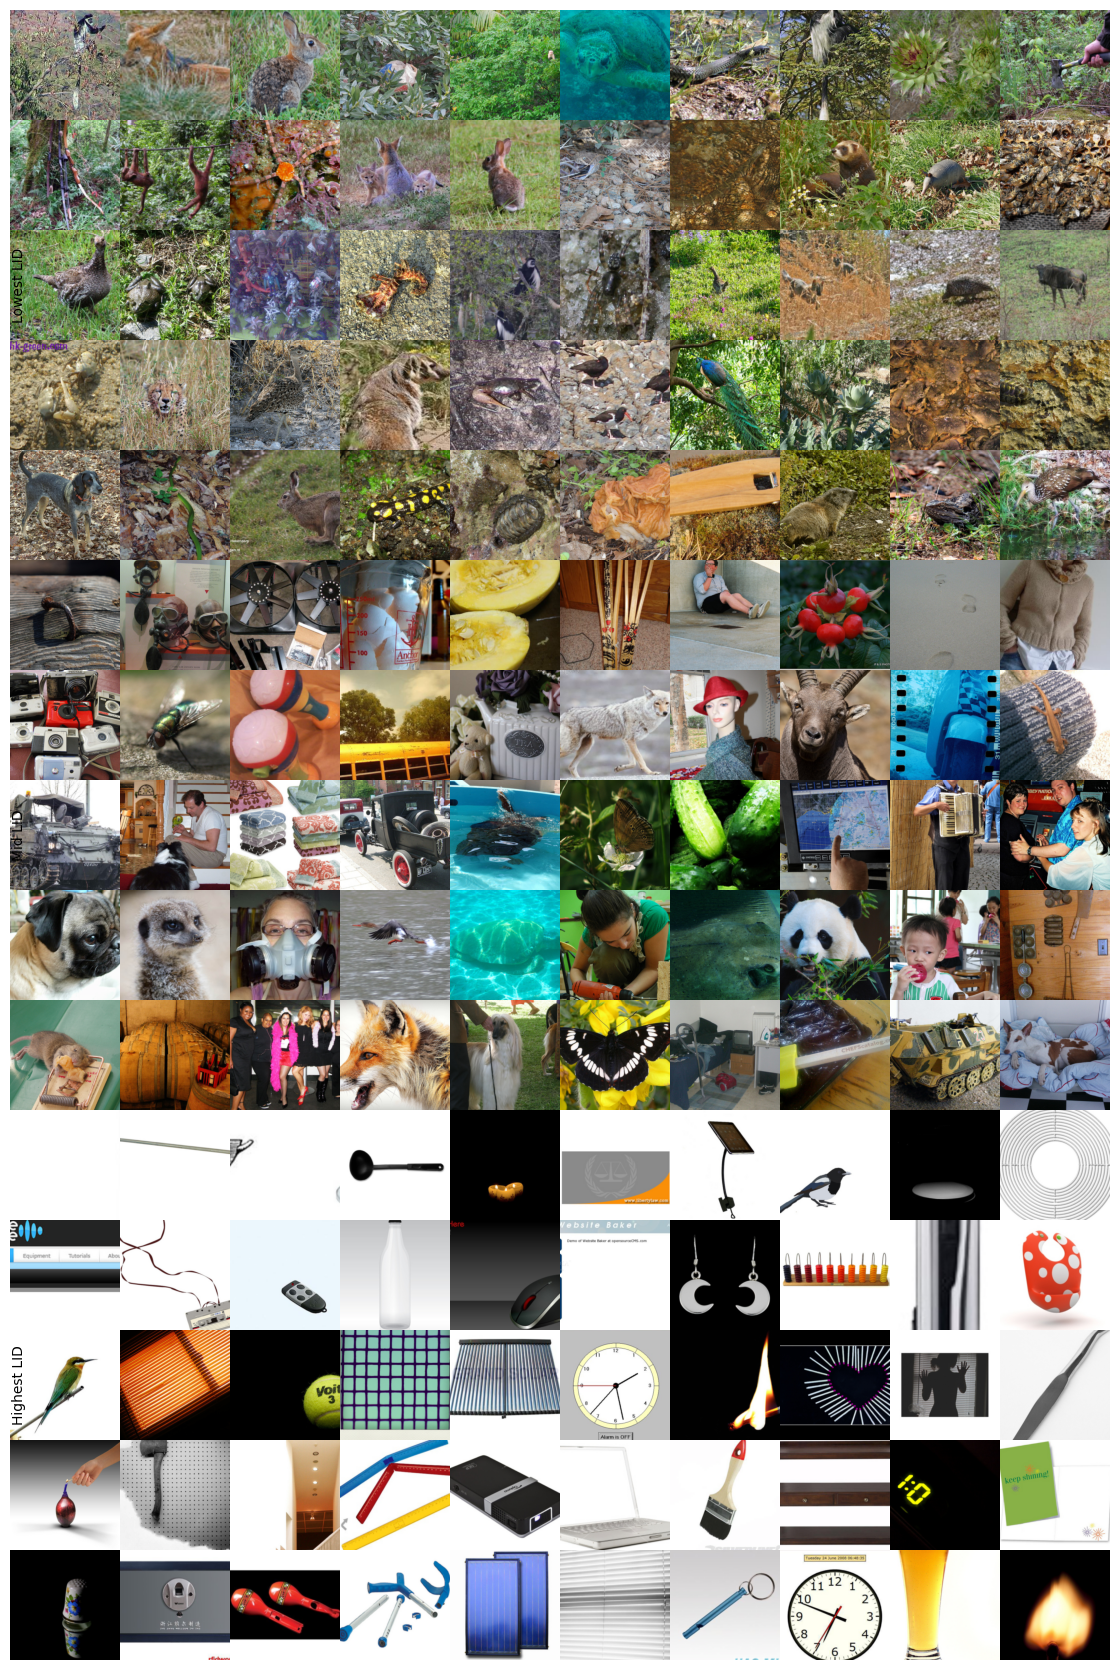

In [7]:
# Compact visualization: remove whitespace and save as PDF
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
n = 50              # images per group
rows, cols = 5, 10  # grid per group
assert rows * cols >= n, "rows*cols must cover n"

# Prepare groups
groups = [
    ("Lowest LID", lowest_indices[:n]),
    ("Mid LID",    mid_indices[:n]),
    ("Highest LID", highest_indices[:n]),
]

H = rows * len(groups)
W = cols
fig_h = 1.1 * H   # figure size scales roughly with tile count
fig_w = 1.1 * W
fig, axs = plt.subplots(H, W, figsize=(fig_w, fig_h))

# Ensure axs is 2D
if H == 1:
    axs = axs[None, :]

# Draw tiles
for gi, (gname, indices) in enumerate(groups):
    for i, idx in enumerate(indices):
        r_local, c = divmod(i, cols)
        r = gi * rows + r_local
        ax = axs[r, c]
        img = imagenet_val.dataset[idx][0]
        img = denormalize(img).clamp(0, 1).permute(1, 2, 0).cpu()
        ax.imshow(img)
        ax.set_axis_off()

# Remove all spacing and margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Minimal group labels on the left margin without changing layout
for gi, (gname, _) in enumerate(groups):
    y = 1 - (gi + 0.5) / len(groups)
    fig.text(0.002, y, gname, va='center', ha='left', fontsize=10, color='black', rotation=90)

# Save outputs with no padding
out_pdf = Path("lid_grid.pdf")
out_png = Path("lid_grid.png")
fig.savefig(out_pdf, bbox_inches='tight', pad_inches=0, dpi=300)
fig.savefig(out_png, bbox_inches='tight', pad_inches=0, dpi=300)
print(f"Saved {out_pdf} and {out_png}")

plt.show()


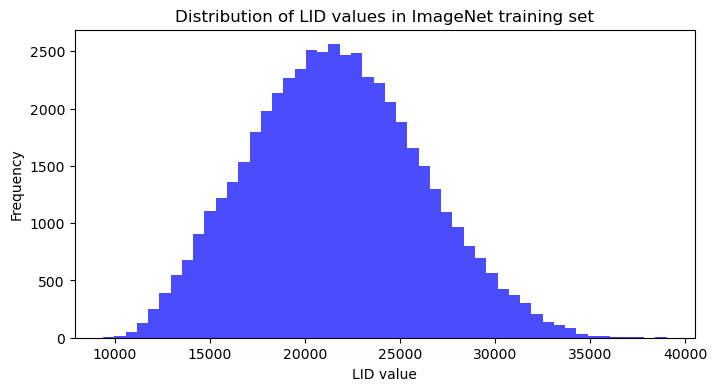

In [10]:
# plot the distribution of LID values
plt.figure(figsize=(8, 4))
plt.hist(lids, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of LID values in ImageNet training set')
plt.xlabel('LID value')
plt.ylabel('Frequency')
plt.show()

In [5]:
# since the LID values can be large and may be negative,
# apply a signed log transform first, then compute mean and std.
# Use NumPy arrays (not Python lists) for vectorized math.
lids_np = np.asarray(all_lids, dtype=np.float64)
mean_lid_before_log = float(lids_np.mean())  # ddof=0 (matches np.std default)
std_lid_before_log = float(lids_np.std())
print(f"Mean LID (signed log1p): {mean_lid_before_log:.4f}, Std LID (signed log1p): {std_lid_before_log:.4f}")

lids_log = np.sign(lids_np) * np.log1p(np.abs(lids_np))
mean_lid_after_log = float(lids_log.mean())  # ddof=0 (matches np.std default)
std_lid_after_log = float(lids_log.std())
print(f"Mean LID (signed log1p): {mean_lid_after_log:.4f}, Std LID (signed log1p): {std_lid_after_log:.4f}")

Mean LID (signed log1p): -5541565.5392, Std LID (signed log1p): 708356.6451
Mean LID (signed log1p): -15.5189, Std LID (signed log1p): 0.1364


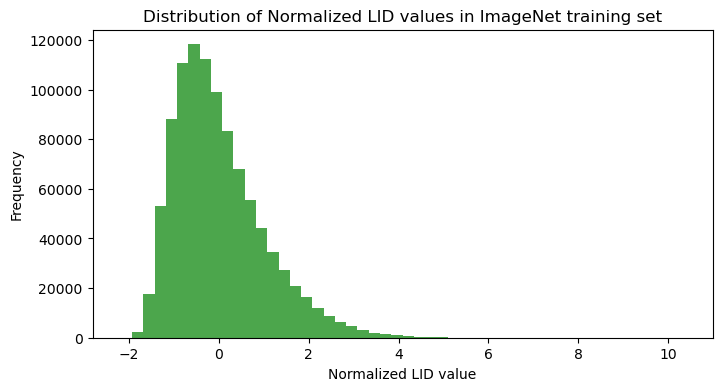

In [7]:
# plot the normalized LID values
lids_normalized_log = (lids_log - mean_lid_after_log) / std_lid_after_log
plt.figure(figsize=(8, 4))
plt.hist(lids_normalized_log, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Normalized LID values in ImageNet training set')
plt.xlabel('Normalized LID value')
plt.ylabel('Frequency')
plt.show()

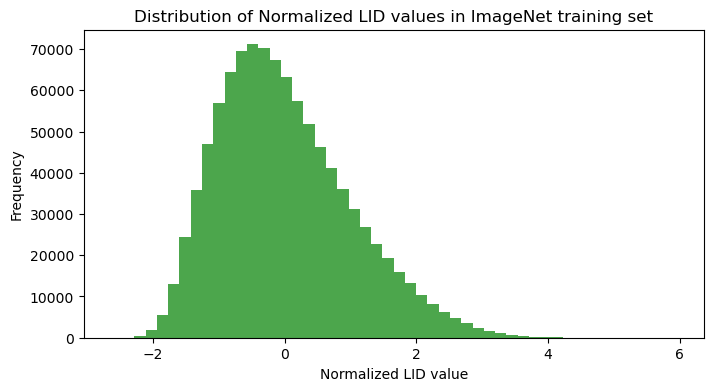

In [8]:
# plot the normalized LID values
lids_normalized = (lids_np - mean_lid_before_log) / std_lid_before_log
plt.figure(figsize=(8, 4))
plt.hist(lids_normalized, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Normalized LID values in ImageNet training set')
plt.xlabel('Normalized LID value')
plt.ylabel('Frequency')
plt.show()